In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 21 18:41:31 2024

@author: youss
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



import tensorflow as tf
from keras import layers, Model

# 1. Encoder
class Encoder(Model):
    def __init__(self, latent):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=layers.LeakyReLU(0.02), padding="same")
        self.conv2 = layers.Conv2D(64, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1024, activation="selu")
        self.mu = layers.Dense(latent)
        self.log_var = layers.Dense(latent)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var


# 2. Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu))  # Sample from normal distribution
        return mu + tf.exp(0.5 * log_var) * epsilon




# 3. Decoder
class Decoder(Model):
    def __init__(self, latent):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(1024, activation="selu")
        self.dense2 = layers.Dense(8192, activation="selu")
        self.reshape = layers.Reshape((4, 4, 512))
        self.deconv1 = layers.Conv2DTranspose(256, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")
        self.deconv2 = layers.Conv2DTranspose(128, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")
        self.deconv3 = layers.Conv2DTranspose(64, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")
        self.deconv4 = layers.Conv2DTranspose(32, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")
        self.output_layer = layers.Conv2DTranspose(3, kernel_size=5, activation="sigmoid", padding="same")

    def call(self, z):
        x = self.dense1(z)
        x = self.dense2(x)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        return self.output_layer(x)


# 4. VAE



class VAE(Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        z = self.sampling([mu, log_var])
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var




class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Adjust input shape to (64, 64, 3)
        self.conv2d1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3))
        self.leaky_relu1 = layers.LeakyReLU()
        self.dropout1 = layers.Dropout(0.3)

        self.conv2d2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.leaky_relu2 = layers.LeakyReLU()
        self.dropout2 = layers.Dropout(0.3)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)  # Output single value for real/fake classification

    def call(self, inputs):
        x = self.conv2d1(inputs)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)
        x = self.conv2d2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x


In [2]:
class GAN:
    def __init__(self, latent):
        self.latent = latent

        #self.vae=VAE(encoder,decoder)
        self.discriminator = Discriminator()
        self.cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
        self.discriminator_optimizer = keras.optimizers.Adam(1e-4)
        self.generator_optimizer = keras.optimizers.Adam(1e-4)
        self.vae = VAE(Encoder(latent), Decoder(latent))


    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss


    # The generator_loss function should be indented to be part of the GAN class
    def generator_loss(self,fake_output, real_images, reconstructed_images, mu, log_var, lambda_recon=1.0, lambda_kl=0.1):
        # Perte adversariale : pousse le discriminateur à croire que les fausses images sont réelles
        adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

        # Perte de reconstruction (MSE ou BCE selon ton choix)
        # Ensure real_images and reconstructed_images have the same shape
        # real_images is actually the discriminator's output for real images,
        # so it's not what we need for the reconstruction loss.
        # Instead, we'll use the original images passed to train_step:

        real_images_for_reconstruction = tf.image.resize(real_images, (reconstructed_images.shape[1], reconstructed_images.shape[2]))
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(real_images_for_reconstruction - reconstructed_images), axis=[1, 2, 3]))

        # Perte KL pour régulariser l’espace latent
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)

        # Combinaison des pertes avec des coefficients de pondération
        return adversarial_loss + lambda_recon * reconstruction_loss + lambda_kl * kl_loss

In [3]:

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')


# Chemin du fichier ZIP dans Google Drive
zip_path = '/content/drive/MyDrive/animefacedataset.zip'

# Répertoire de destination pour décompresser les fichiers
extract_path = '/content/anime_faces'


Mounted at /content/drive


Fichiers extraits dans : /content/anime_faces
63565


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


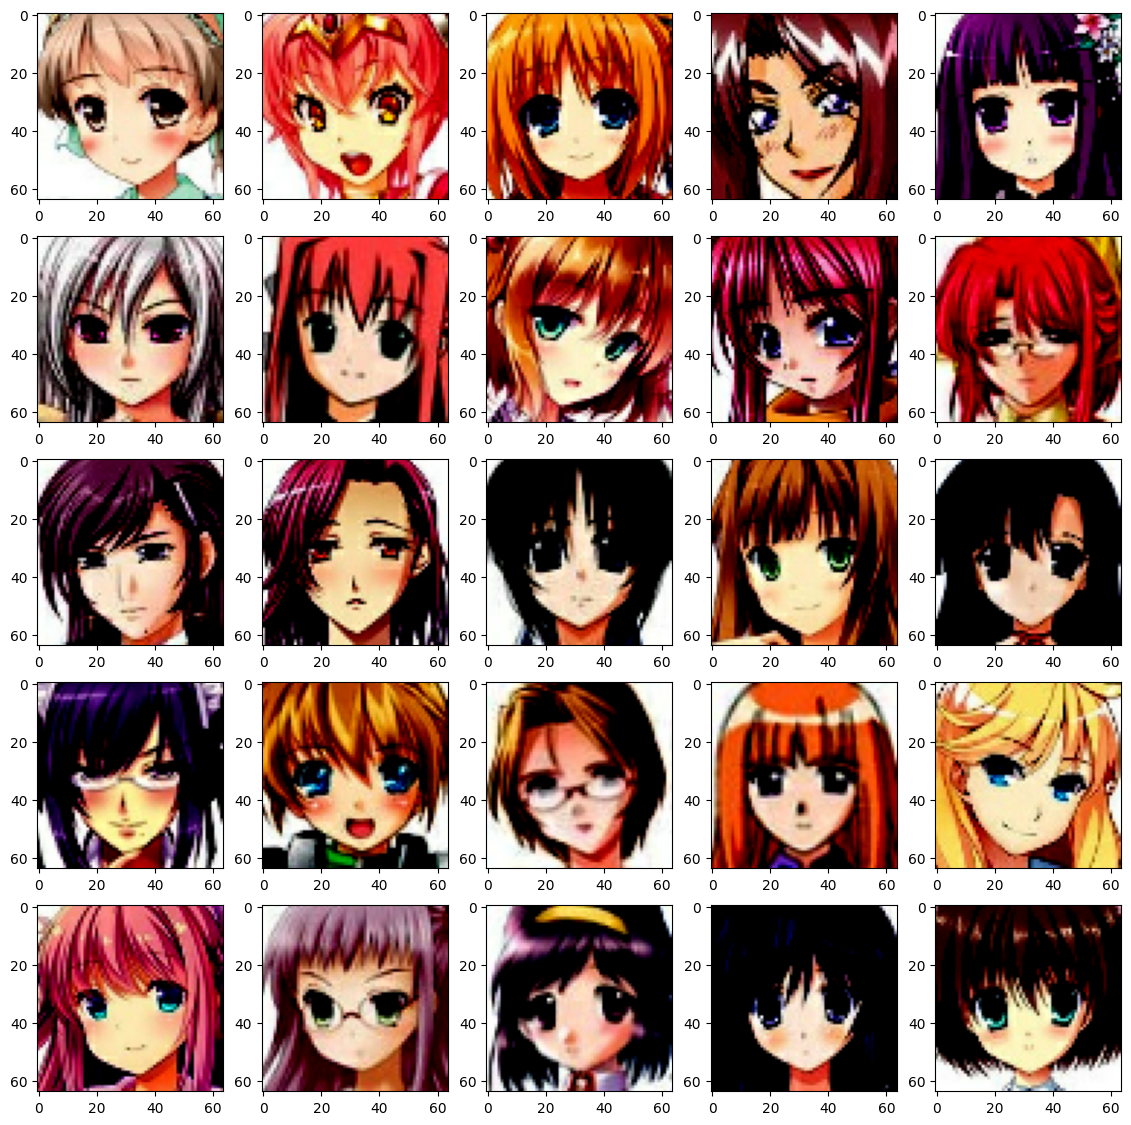

In [4]:

# Décompresser le fichier
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Fichiers extraits dans : {extract_path}")


# Chemin vers le dossier des images extraites
image_dir = r'/content/anime_faces/images'

# Charger les images depuis le dossier
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]

# Afficher les 6 premières images
images[:6]

image_size = 64

def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (64, 64))
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

batch_size = 64

training_dataset = tf.data.Dataset.from_tensor_slices((images)) #Si images contient les chemins d'accès : alors le Dataset résultant contiendra seulement les chemins des fichiers

print(len(training_dataset))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

len(training_dataset)


# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])#imshow peut détecter que les valeurs des pixels sont entre 0 et 1 (au lieu de 0 et 255) et ajuste l'affichage pour montrer les images correctement
        idx+=1



latent_dim = 100
batch_size = 256
epochs = 50
gan = GAN(latent_dim)

#@tf.function
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure the output directory exists
output_dir = '/content/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Your existing train_step and train functions remain the same




In [5]:
sample_batch = next(iter(training_dataset))
print("Batch type:", type(sample_batch))

Batch type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [6]:
sample_batch.shape

TensorShape([64, 64, 64, 3])

In [7]:
def train_step(images,gan1):

    # Train discriminator
    with tf.GradientTape() as disc_tape:

        reconstructed , mu, log_var=gan1.vae(images,training=True)
        real_output = gan1.discriminator(images, training=True)
        fake_output = gan1.discriminator(reconstructed, training=True)
        disc_loss = gan1.discriminator_loss(real_output, fake_output)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, gan1.discriminator.trainable_variables)
        gan1.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, gan1.discriminator.trainable_variables))

    # Train generator
    with tf.GradientTape() as gen_tape:
        reconstructed, mu, log_var=gan1.vae(images,training=True)
        fake_output = gan1.discriminator(reconstructed, training=True)
        # real_output is not needed in generator_loss anymore
        gen_loss = gan1.generator_loss(fake_output,images,reconstructed,mu, log_var)  # Pass 'images' instead of 'real_output'
        gradients_of_generator = gen_tape.gradient(gen_loss, gan1.vae.trainable_variables)
        gan1.generator_optimizer.apply_gradients(zip(gradients_of_generator, gan1.vae.trainable_variables))


    return disc_loss, gen_loss


In [10]:
disc_error=np.array([0])
gen_error=np.array([0])

def train(dataset, epochs,gan1):
    disc_tot=tf.zeros((1,1))
    gen_tot=tf.zeros((1,1))
    for epoch in range(epochs):
        for image_batch in dataset:
            disc_loss, gen_loss  = train_step(image_batch,gan1)
            disc_tot+=disc_loss/epochs
            gen_tot+=gen_loss/epochs

        """  disc_mean=tf.reduce_mean(disc_tot, axis=None, keepdims=False)
        gen_mean=tf.reduce_mean(gen_tot, axis=None, keepdims=False)"""
        disc_error.append(disc_tot.numpy())
        gen_error.append(gen_tot.numpy())
        print(f'Epoch {epoch+1}, Gen Loss: {gen_mean.numpy()}, Disc Loss: { disc_mean.numpy()}')
        random_vector = tf.random.normal(shape = (25, latent_dim,))
        # Generate and save sample images
        generate_and_save_images(gan1.vae.decoder, epoch + 1, random_vector)#generate_and_save_images(gan.generator, epoch + 1, tf.random.normal([16, latent_dim]))


"""def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i + 1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2, cmap='gray')
        plt.axis('off')

    # Save the image to the output directory
    image_path = os.path.join(output_dir, f'image_at_epoch_{epoch:04d}.png')
    plt.savefig(image_path)
    plt.show()"""




def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    for i in range(predictions.shape[0]):
        image = (predictions[i, :, :, 0] + 1) / 2  # Normalisation des valeurs entre 0 et 1
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        # Sauvegarde de chaque image individuellement
        image_path = os.path.join(output_dir, f'epoch_{epoch:04d}_image_{i+1:02d}.png')
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
        plt.close()


In [11]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

# Utilisation de listes au lieu de np.array pour éviter l'erreur de .append()
disc_error = []
gen_error = []

def train(dataset, epochs, gan1):
    for epoch in range(epochs):
        disc_tot = 0.0  # Réinitialisation des accumulateurs à chaque époque
        gen_tot = 0.0

        for image_batch in dataset:
            disc_loss, gen_loss = train_step(image_batch, gan1)
            disc_tot += disc_loss.numpy()
            gen_tot += gen_loss.numpy()

        # Calcul de la moyenne des erreurs pour l'époque
        disc_mean = disc_tot / len(dataset)
        gen_mean = gen_tot / len(dataset)

        # Stockage des erreurs
        disc_error.append(disc_mean)
        gen_error.append(gen_mean)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_mean}, Disc Loss: {disc_mean}')

        # Génération et sauvegarde d'images
        random_vector = tf.random.normal(shape=(25, latent_dim))
        generate_and_save_images(gan1.vae.decoder, epoch + 1, random_vector)


def generate_and_save_images(model, epoch, test_input, output_dir="output_images"):
    os.makedirs(output_dir, exist_ok=True)  # Création du dossier si inexistant
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        image = (predictions[i, :, :, 0] + 1) / 2  # Normalisation entre 0 et 1
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        # Sauvegarde de chaque image individuellement
        image_path = os.path.join(output_dir, f'epoch_{epoch:04d}_image_{i+1:02d}.png')
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
        plt.close()


In [12]:

# Call the training function
train(training_dataset, epochs,gan)



Epoch 1, Gen Loss: 1971.2962479466644, Disc Loss: 0.07191811698609288
Epoch 2, Gen Loss: 1609.4421611455844, Disc Loss: 0.01167128638650904
Epoch 3, Gen Loss: 1539.4248728454713, Disc Loss: 0.011089447500936647
Epoch 4, Gen Loss: 1512.8615204410055, Disc Loss: 0.007583430554529351
Epoch 5, Gen Loss: 1498.8122917190644, Disc Loss: 0.005992084905001339
Epoch 6, Gen Loss: 1487.4386018257985, Disc Loss: 0.0058902482509387176
Epoch 7, Gen Loss: 1478.3887480154365, Disc Loss: 0.005210245894710934
Epoch 8, Gen Loss: 1471.1421753175302, Disc Loss: 0.0041548412152010855
Epoch 9, Gen Loss: 1463.6889620191855, Disc Loss: 0.003689978910897187
Epoch 10, Gen Loss: 1457.5079059562454, Disc Loss: 0.0031038494163658104
Epoch 11, Gen Loss: 1451.590389750613, Disc Loss: 0.002750125132299732
Epoch 12, Gen Loss: 1446.1919684611576, Disc Loss: 0.00274468129816636
Epoch 13, Gen Loss: 1441.4514171208893, Disc Loss: 0.002174490271327488
Epoch 14, Gen Loss: 1437.185489155637, Disc Loss: 0.0022869774112053167
Ep

KeyboardInterrupt: 

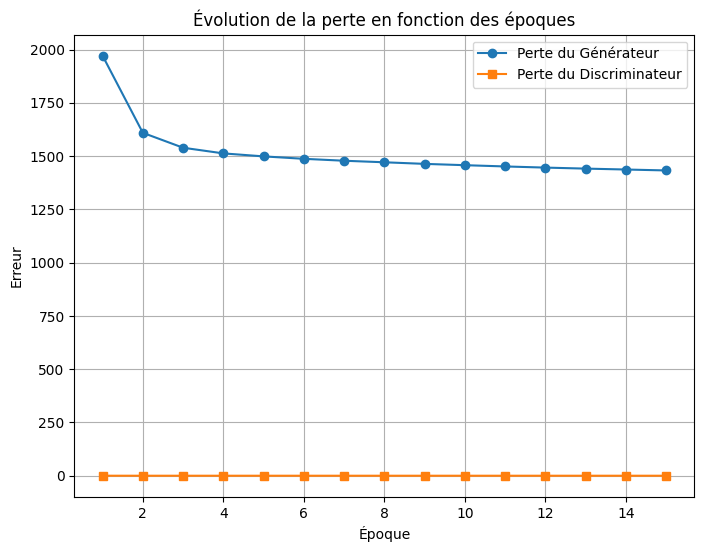

In [13]:
def plot_losses(gen_error, disc_error):
    epochs = range(1, len(gen_error) + 1)  # Création de la liste des époques

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, gen_error, label="Perte du Générateur", marker='o', linestyle='-')
    plt.plot(epochs, disc_error, label="Perte du Discriminateur", marker='s', linestyle='-')

    plt.xlabel("Époque")
    plt.ylabel("Erreur")
    plt.title("Évolution de la perte en fonction des époques")
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'appel (une fois que tu as rempli disc_error et gen_error avec le training)
plot_losses(gen_error, disc_error)